# Qubit Rotation

To see how PennyLane allows the easy construction and optimization of quantum functions, let’s consider the simple case of qubit rotation — the PennyLane version of the ‘Hello, world!’ example.

<font color=brown> **GOAL:** To optimize two rotation gates in order to flip a `single qubit` from state $\mid0\rangle$ to state $\mid1\rangle$.</font>

### The Quantum Circuit

In the basic example, we wish to implement the following quantum circuit:

Breaking this down step-by-step:

We first start with a qubit in the ground state $\mid0\rangle$ and rotate it around the x-axis by applying the gate:

$$ R_x(\phi_1)=e^{-i \phi_1\frac{\sigma_x}{2}}=\begin{pmatrix} \cos(\frac{\phi_1}{2}) &  -i\sin(\frac{\phi_1}{2}) \\ -i\sin(\frac{\phi_1}{2}) & \cos(\frac{\phi_1}{2}) \end{pmatrix}$$

and then around the y-axis via the gate:

$$ R_y(\phi_2)=e^{-i \phi_2\frac{\sigma_y}{2}}=\begin{pmatrix} \cos(\frac{\phi_2}{2}) &  -\sin(\frac{\phi_2}{2}) \\ \sin(\frac{\phi_2}{2}) & \cos(\frac{\phi_2}{2}) \end{pmatrix}$$

After these operations, the qubit is in the state:

$$\mid\psi\rangle=R_y(\phi_2)R_x(\phi_1)\mid0\rangle$$

Finally, we measure the expectation value of the Pauli-Z operator $\langle\psi\mid\hat{\sigma}_z\mid\psi\rangle$ where:

$$\hat{\sigma}_z=\begin{pmatrix} 1 &  0 \\ 0 & -1 \end{pmatrix}$$

Using the above to calculate the exact expectation value, we find that:

$$\langle\psi\mid\hat{\sigma}_z\mid\psi\rangle = \langle0\mid R_x(\phi_1)^{\dagger}R_y(\phi_2)^{\dagger}\hat{\sigma}_zR_y(\phi_2)R_x(\phi_1)\mid0\rangle = \cos(\phi_1)\cos(\phi_2)$$

Depending on the circuit parameters $\phi_1$ and $\phi_2$, the output expectation lies between `1` (if $\mid\psi\rangle = \mid0\rangle$) and `-1 `(if $\mid\psi\rangle = \mid1\rangle$)

Let’s see how we can easily `implement` and `optimize` this circuit using PennyLane.

#### PennyLane Execution

In [1]:
# lets first import the essentials
import pennylane as qml
from pennylane import numpy as np

In [2]:
#create a device
dev1 = qml.device('default.qubit', wires=1)

In [3]:
#construct a QNode
@qml.qnode(dev1)
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval.PauliZ(0)

Let’s make use of PennyLane’s built-in optimizers to optimize the two circuit parameters $\phi_1$ and $\phi_2$ such that the qubit, originally in state $\mid0\rangle$, is rotated to be in state $\mid1\rangle$. <font color=brown> This is equivalent to measuring a Pauli-Z expectation value of `-1` since the state $\mid1\rangle$ is an eigenvector of the Pauli-Z matrix with eigenvalue $\lambda = −1$.</font>

In other words, the optimization procedure will find the weights $\phi_1$ and $\phi_2$ that result in the following rotation on the Bloch sphere:

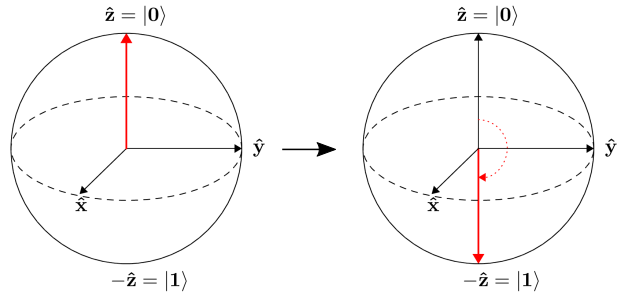

As our desired outcome is a Pauli-Z expectation value of `−1`, we can define our cost directly as the output of the `QNode`:

In [4]:
def cost(var):
    return circuit(var)

To begin our optimization, let’s choose small initial values of $\phi_1$ and $\phi_2$:

In [5]:
init_params = np.array([0.011, 0.012])
cost(init_params)

0.9998675058299389

We can see that, for these initial parameter values, the cost function is close to 1.

Finally, we use the PennyLane optimizer to update the circuit parameters for 100 steps:

In [6]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

In [7]:
# set the number of steps
steps = 100

# set the initial parameter values
params = init_params

In [8]:
for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    #print cost after every 5 steps
    if (i+1) % 5 == 0:
        print('Cost after step {:5d}: {: .7f}'.format(i+1, cost(params)))

Cost after step     5:  0.9961778
Cost after step    10:  0.8974944
Cost after step    15:  0.1440490
Cost after step    20: -0.1536720
Cost after step    25: -0.9152496
Cost after step    30: -0.9994046
Cost after step    35: -0.9999964
Cost after step    40: -1.0000000
Cost after step    45: -1.0000000
Cost after step    50: -1.0000000
Cost after step    55: -1.0000000
Cost after step    60: -1.0000000
Cost after step    65: -1.0000000
Cost after step    70: -1.0000000
Cost after step    75: -1.0000000
Cost after step    80: -1.0000000
Cost after step    85: -1.0000000
Cost after step    90: -1.0000000
Cost after step    95: -1.0000000
Cost after step   100: -1.0000000


Try this yourself — the optimization should converge after approximately 40 steps, giving the following numerically optimum values of $\phi_1$ and $\phi_2$:

In [9]:
#print final result
print('Optimized rotation angles: {}'.format(params))

Optimized rotation angles: [3.93868160e-17 3.14159265e+00]


Substituting this into the theoretical result $\langle\psi\mid\hat{\sigma}_z\mid\psi\rangle=\cos(\phi_1)\cos(\phi_2)$, we can verify that this is indeed one possible value of the circuit parameters that produces $\langle\psi\mid\hat{\sigma}_z\mid\psi\rangle=-1$, resulting in the qubit being rotated to the state $\mid1\rangle$.

<font color=brown> **Note:** Some optimizers, such as `AdagradOptimizer`, have internal hyperparameters that are stored in the optimizer instance. These can be reset using the `reset()` method.</font>

Continue on to the next tutorial, Gaussian transformation, to see a similar example using `continuous-variable` (CV) quantum nodes.